In [19]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.prompts.image import ImagePromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.runnables import chain as chain_decorator
from langchain_openai import ChatOpenAI

import base64
import os
from getpass import getpass
from IPython import display
import json

from typing import List, Optional
from typing_extensions import TypedDict

from playwright.async_api import Page, async_playwright



def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")

import asyncio

# shorthand for the class whose __del__ raises the exception
_BEL = asyncio.base_events.BaseEventLoop

_original_del = _BEL.__del__

def _patched_del(self):
    try:
        # invoke the original method...
        _original_del(self)
    except:
        # ... but ignore any exceptions it might raise
        # NOTE: horrible anti-pattern
        pass

# replace the original __del__ method
_BEL.__del__ = _patched_del


_getpass("OPENAI_API_KEY")

import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define graph

### Define graph state

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [20]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, max_tokens=4096)

In [21]:
class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    resume: str
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str # The most recent response from a tool

### Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [22]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    
    if bbox["type"] == "select":
        selectOptions = bbox["selectOptions"]
        surroundingText = bbox["surroundingText"]
        img = state["img"]
        resume = state["resume"]

        system_message = SystemMessagePromptTemplate.from_template(
            """
            You are given a select html element along with all of the options it can take on. Given the user's resume, surroundingText of the element, a screenshot of the webpage which will contain information about the description of the select element
            please determine what is the best option to choose for this select input.

            <selectOptions>
            {selectOptions}
            </selectOptions>

            <surroundingText>
            {surroundingText}
            </surroundingText>
            
            <usersResume>
            {usersResume}
            </usersResume>

            REPLY BACK ONLY WITH THE SELECTED OPTION. DON'T ADD ANY SURROUNDING TEXT OR ANY OTHER TEXT. THE REPLY MUST STRICTLY BE THE OPTION YOU FEEL IS BEST.
            """
        )

        image_prompt_template = ImagePromptTemplate(input_variables=['img'], template={"url": "data:image/png;base64,{img}"})
        image_prompt_template = HumanMessagePromptTemplate(prompt=[image_prompt_template])
        select_prompt = ChatPromptTemplate.from_messages([
            system_message,
            image_prompt_template
        ])

        select_llm_chain = select_prompt | llm | StrOutputParser()

        response = select_llm_chain.invoke({"selectOptions": selectOptions, "surroundingText": surroundingText, "usersResume": resume, "img": img})
        await page.locator(f'select[name={bbox["name"]}]').select_option(response)
        return f"Selected {bbox_id} and chose option {response}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

### Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [9]:
browser = await async_playwright().start()
browser = await browser.chromium.launch(headless=False, args=None)
context = await browser.new_context()
page = await context.new_page()
await page.goto("https://wing.com/careers/7654023002/?gh_jid=7654023002&gh_src=7d0d80872us")

<Response url='https://wing.com/careers/7654023002/?gh_jid=7654023002&gh_src=7d0d80872us' request=<Request url='https://wing.com/careers/7654023002/?gh_jid=7654023002&gh_src=7d0d80872us' method='GET'>>

In [23]:
with open("mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator 
async def mark_page(page):
    indexCounter = 0
    all_bboxes = []  # To store bounding boxes from all frames

    for index, frame in enumerate(page.frames):
        try:
            # Print details about the frame for debugging
            # print(f"Processing frame {index}: URL = {frame.url}")


            if frame != page.main_frame:
                # Check if frame is still attached before accessing it
                frame_element_handle = await frame.frame_element()
                frame_box = await frame_element_handle.bounding_box()

            if frame != page.main_frame and frame_box == None:
                continue
            # Mark the page elements within the current frame
            await frame.evaluate(mark_page_script)
            
            # Try to get bounding boxes with retries
            frame_bboxes = None
            for _ in range(10):
                try:
                    marking_object = await frame.evaluate("(indexCounter) => markPage(indexCounter)", indexCounter)
                    frame_bboxes = marking_object['coordinates']
                    indexCounter = marking_object['indexCounter']
                    if frame_bboxes and frame != page.main_frame:
                        # Adjust bounding boxes to be relative to the entire page
                        for bbox in frame_bboxes:
                            bbox["x"] += frame_box["x"]
                            bbox["y"] += frame_box["y"]
                    all_bboxes.extend(frame_bboxes)
                    break
                except Exception as e:
                    print(f"Error during bounding box retrieval in frame {index} ({frame.url}): {e}")
                    print(e)
                    await asyncio.sleep(3)

        except Exception as e:
            print(f"Error accessing frame {index} ({frame.url}): {e}")
            continue  # Skip to the next frame if detached or an error occurs

    # Take a screenshot of the page after marking
    screenshot = await page.screenshot()

    # Ensure the bounding boxes don’t follow to the next frame by unmarking
    for index, frame in enumerate(page.frames):
        try:
            # print(f"Unmarking frame {index}: URL = {frame.url}")
            # await frame.evaluate(mark_page_script)
            await frame.evaluate("unmarkPage()")
        except Exception as e:
            # print(f"Error unmarking elements in frame {index} ({frame.url}): {e}")
            # print(e)
            # Continue to the next frame
            pass

    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": all_bboxes,
    }


In [ ]:
# values = await mark_page(page)
# from IPython import display
# display.display(display.Image(base64.b64decode(values['img'])))

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [24]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        placeholder = bbox["placeholder"]
        id = bbox["id"]
        name = bbox["name"]

        # Create a dictionary of non-empty fields, excluding 'text' for select elements
        label_dict = {k: v for k, v in {
            "element_type": f'<{el_type}>',
            "text": text if el_type != "select" else None,
            "id": id,
            "placeholder": placeholder,
            "name": name
        }.items() if v}

        # Format the label string with the entire set of properties enclosed in {}
        label_str = f'{i} : {{{", ".join(f"{k}: {v}" for k, v in label_dict.items())}}}'
        labels.append(label_str)
        
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

# Prompts

In [25]:
system_prompt_string = """
Imagine you are a robot skilled for applying to job applications, just like humans. 
Now your goal is to apply to a job by navigating through the job website and 
taking the correct actions (i.e click apply, fill in input field, etc) until 
you have fully applied. In each iteration, you will receive an Observation that 
includes a screenshot of the current webpage state and some texts that represent 
the interactive elements present in the webpage. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 

Your goal:
Given the screenshot which contains bounding boxes around interactive elements (i.e buttons, input fields, selects, etc), 
your goal is to predict the next interactive
action to take given the current state of the browser represented through the screenshot.
The interactive actions which are available to you are as follows

1. Click a Web Element.
2. Type content on an input field
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

For the action chosen, the return format will be STRICTLY as follows for each action. MAKE SURE NOTHING ADDITIONAL IS ADDED TO THE RETURN FORMAT:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content to type in] 
- Scroll [Numerical_Label or WINDOW]; [up or down]
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes.



* Web Browsing Guidelines *
1) Select strategically to minimize time wasted.
2) If you realize that you are repeating actions, then either go back or try something new!
3) Likely if you can't find anything useful to interact with on the current screen, or you feel you need more information, PLEASE use the scroll action! Do NOT click random buttons. Scroll to find out more
4) If there aren't form fields, look for "apply buttons", "register, sign up, login meta actions", etc
5) For scrollling, window means scroll the entire window, numerical label means you want to scroll on a specific element. Likely if it's unclear, you want to scroll on the actual window
6) I repeat, DO NOT click random buttons if you don't have enough information! Scroll instead to find out more!
7) If it's MM or YYYY then type in the month or year in the numerical format. Same with year, or day. For example June = 06.
8) After typing in a field, if a newer dropdown pops up, please select an item in the dropdown!

Your reply should STRICTLY follow the format:

Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
Action: {{One Action format you choose}}
Then the User will provide:
Observation: {{A labeled screenshot Given by User}}
"""

system_prompt_template = SystemMessagePromptTemplate.from_template(system_prompt_string)

message_placeholder = MessagesPlaceholder("scratchpad", optional=True)

image_prompt_template = ImagePromptTemplate(input_variables=['img'], template={"url": "data:image/png;base64,{img}"})
image_prompt_template = HumanMessagePromptTemplate(prompt=[image_prompt_template])

human_prompt_template_one = HumanMessagePromptTemplate.from_template(
  """
  Here are the valid bounding boxes for the current interactive elements on the screen:
  {bbox_descriptions}
  """
)

human_prompt_template_resume = HumanMessagePromptTemplate.from_template(
  """

  This is the users resume:
  {resume}
  """
)

human_prompt_template_two = HumanMessagePromptTemplate.from_template("{input}")

In [26]:
prompt = ChatPromptTemplate.from_messages([
  system_prompt_template,
  message_placeholder,
  image_prompt_template,
  human_prompt_template_one,
  human_prompt_template_resume,
  human_prompt_template_two
])

In [27]:
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [28]:
import json
resume = json.load(open("./profile.json"))

In [29]:
state = {
  "page": page,
  "input": "please apply to this job.",
  "resume": resume,
  "scratchpad": [],
}

In [ ]:
import sys
import os
import base64
import json
from langchain_core.runnables import RunnableLambda, RunnableParallel
from operator import itemgetter
from IPython import display

# Function to convert messages to the desired format
def convert_messages_to_json(messages):
    json_messages = []
    for message in messages:
        if isinstance(message, SystemMessage):
            json_messages.append({"role": "system", "content": message.content})
        elif isinstance(message, HumanMessage):
            if isinstance(message.content, list):
                json_messages.append({"role": "user", "content": message.content})
            else:
                json_messages.append({"role": "user", "content": message.content})
    return json_messages

async def capture_and_label(state):
    # Save the original stderr
    original_stderr = sys.stderr

    # Redirect stderr to null to suppress error messages
    sys.stderr = open(os.devnull, 'w')

    try:
        agent_test = RunnableParallel({
            "img": RunnableLambda(annotate) | itemgetter("img"),
            "finalized_prompt": RunnableLambda(annotate) | format_descriptions | prompt
        })
        values = await agent_test.ainvoke(state)
    except Exception as e:
        pass
    finally:
        # Restore the original stderr
        sys.stderr.close()
        sys.stderr = original_stderr

    # Display the image
    display.display(display.Image(base64.b64decode(values['img'])))

    # Prompt the user for a label
    label = input("Enter a label for the screenshot: ")

    # Convert the messages
    json_format = {
        "messages": convert_messages_to_json(values["finalized_prompt"].messages) + [{"role": "assistant", "content": label}]
    }

    # Convert to JSONL format
    jsonl_string = json.dumps(json_format, indent=2)

    # Print or save the JSONL string
    print(jsonl_string)

    # Optionally, save to a file
    with open("dataset.jsonl", "a") as f:
        f.write(jsonl_string + "\n")

# Example usage
state = {
  "page": page,
  "input": "please apply to this job.",
  "resume": resume,
  "scratchpad": [],
}
test = await capture_and_label(state)

## Compile the graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [304]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [305]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

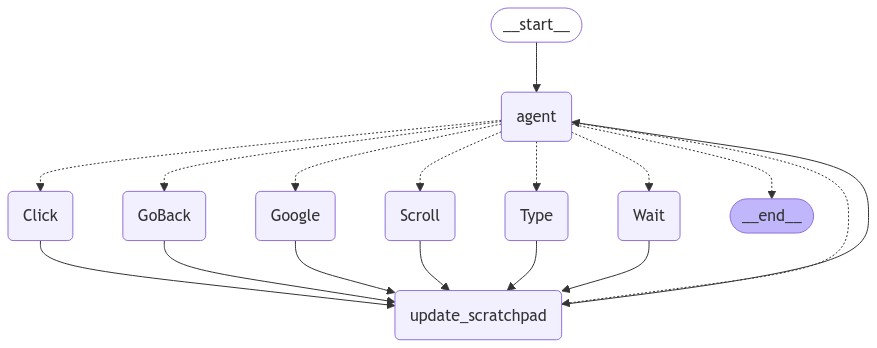

In [269]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [290]:
import re

async def handler(file_chooser):
    element = file_chooser.element
    element_string = str(element)

    # Define patterns for resume and cover letter
    resume_pattern = re.compile(r'resume', re.IGNORECASE)
    cover_letter_pattern = re.compile(r'cover\s*letter', re.IGNORECASE)

    # Check if the element string matches the patterns
    if resume_pattern.search(element_string):
        print("Resume field detected. Uploading resume...")
        await file_chooser.set_files('Tawsif_Kamal_resume.pdf')
    elif cover_letter_pattern.search(element_string):
        print("Cover letter field detected. Uploading cover letter...")
        await file_chooser.set_files('Cover_Letter.pdf')
    else:
        print("No matching field detected.")

# Attach the handler to the page
page.on("filechooser", handler)

## Use the graph

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [306]:
async def call_agent(question: str, page, max_steps: int = 150):
    resume = json.load(open("./profile.json"))
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "resume": resume,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

In [307]:
prompt_input = """ 
Navigate this job posting and please apply to this job for me.
"""

In [ ]:
res = await call_agent(prompt_input, page)
print(f"Final response: {res}")